In [11]:
import locale
from pathlib import Path
from typing import Sequence

import matplotlib.axes._axes as axes
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Figure

In [12]:
PATH = Path(r"C:\Users\balco\Downloads\phd_data")
# 81 Days of data
DAY_INDEX = [0, 4, 7, 26, 32, 46, 49, 54] # day
DAY_INDEX_MEAN = [0, 4, 7, 26, 32, 46, 49, 54] # day and mean
FOLDER_INDEX = [1]

CB91_Blue = "#2CBDFE"
CB91_Green = "#47DBCD"
CB91_Pink = "#F3A0F2"
CB91_Purple = "#9D2EC5"
CB91_Violet = "#661D98"
CB91_Amber = "#F5B14C"

color_list = [
    CB91_Blue,
    CB91_Amber,
    CB91_Green,
    CB91_Violet,
    CB91_Pink,
    CB91_Purple,
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_list)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

locale.setlocale(locale.LC_ALL, 'es-MX')
LOCATOR = mdates.AutoDateLocator(minticks=3, maxticks=5)
FORMATTER = mdates.ConciseDateFormatter(LOCATOR)


In [13]:
def mean_across_dataframes(dfs: Sequence[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(dfs).groupby(level=0).mean()


def read_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True)

    return df


def get_dirs(name: str):
    """Get all directories which contain the specified word in their name"""
    return PATH.glob(f"*{name}*")


def get_file_from_dir(dir_: Path, index: int):
    """Get the csv at the specified position"""
    return list(dir_.glob("*.csv"))[index]


def get_files(name: str, index: int):
    """
    Get the csv files at the specified position for all the directories which contain the word `name`
    """
    return (get_file_from_dir(d, index) for d in get_dirs(name))


def combine_df(
    dfs: Sequence[pd.DataFrame], names: Sequence[str], feature: str = "Power", feat_opt: str = "Optimum Power"
) -> pd.DataFrame:
    """
    Combine multiple dataframes into a single one
    """

    combined_df = {}

    if feat_opt:
        combined_df[names[-1]] = dfs[0][feat_opt]

    for df, name in zip(dfs, names):
        combined_df[name] = df[feature]

    return pd.DataFrame(combined_df)


def plot_combined(df: pd.DataFrame, ylabel: str = "", multiplier: int = 1, locator=None, formatter=None) -> Figure:
    locator = locator or LOCATOR
    formatter = formatter or FORMATTER

    df = add_year_offset(df)

    fig = plt.figure()
    ax: axes.Axes = fig.add_subplot(111)

    effs = compute_eff(df)

    for column, eff in zip(df.columns, effs):
        label = f'{column} ({eff:.1f}\%)'
        ax.plot(df.index, df[column] * multiplier, label=label)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc="lower right")

    ax.set_ylabel(ylabel)
    ax.set_ylim(-10, 110)

    return fig


def compute_eff(df: pd.DataFrame) -> pd.DataFrame:
    df1 = df.mean()

    # names = df1.index[:]
    return df1.values[:] * 100

def add_year_offset(df: pd.DataFrame) -> pd.DataFrame:
    df.index = df.index + pd.DateOffset(years=1)
    return df

In [14]:
def main_plot_test_day():
    for i, day in enumerate(DAY_INDEX):
        for j, folder in enumerate(FOLDER_INDEX):
            po_test_files = [list(get_files("po_test", day))[0]]
            ddpg_test_files = [list(get_files("ddpg_test", day))[folder]]
            td3_test_files = [list(get_files("td3_test", day))[folder]]
            td4_test_files = [list(get_files("td3exp_test", day))[folder]]

            assert len(po_test_files) == 1
            assert len(ddpg_test_files) == 1
            assert len(td3_test_files) == 1
            assert len(td4_test_files) == 1

            po_mean = mean_across_dataframes(read_csv(f) for f in po_test_files)
            ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_test_files))
            td3_mean = mean_across_dataframes((read_csv(f) for f in td3_test_files))
            td4_mean = mean_across_dataframes((read_csv(f) for f in td4_test_files))

            df = combine_df(
                [po_mean, ddpg_mean, td3_mean, td4_mean],
                ["P\&O","DDPG", "TD3", "TD4"],
                feature="Efficiency", feat_opt=None
            )

            p = plot_combined(df, ylabel="Eficiencia de seguimiento (\%)", multiplier=100)

            p.savefig(f"output\\fig_15_mppt_comparison_test_efficiency_day_{j:04}_{i:02}.pdf", bbox_inches="tight")

            # plt.close(p)

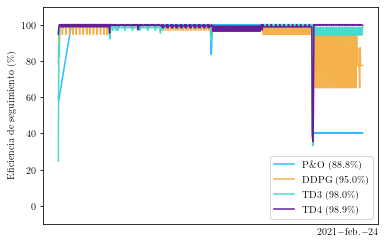

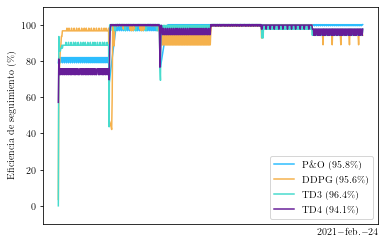

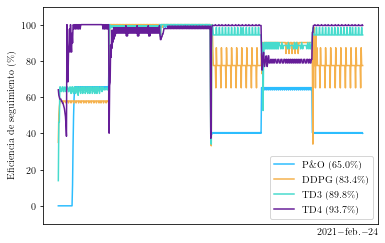

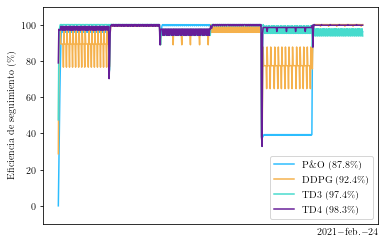

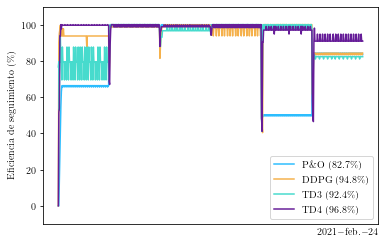

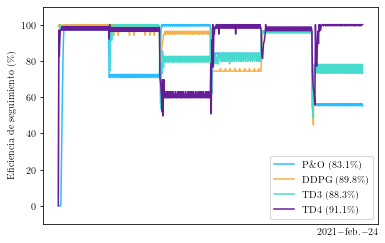

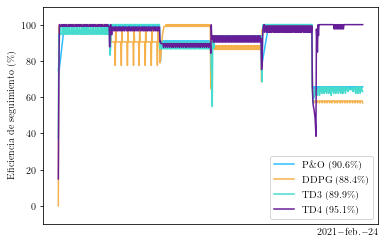

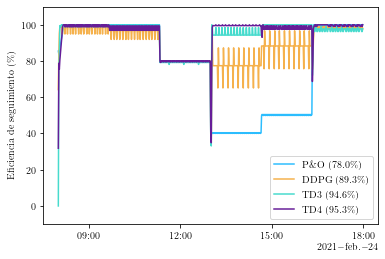

In [15]:
main_plot_test_day()

In [16]:
def main_plot_test_mean():
    for i, day in enumerate(DAY_INDEX_MEAN):
        po_test_files = [list(get_files("po_test", day))[0]]
        ddpg_test_files = list(get_files("ddpg_test", day))
        td3_test_files = list(get_files("td3_test", day))
        td4_test_files = list(get_files("td3exp_test", day))

        assert len(po_test_files) == 1
        assert len(ddpg_test_files) == 110
        assert len(td3_test_files) == 110
        assert len(td4_test_files) == 110

        po_mean = mean_across_dataframes(read_csv(f) for f in po_test_files)
        ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_test_files))
        td3_mean = mean_across_dataframes((read_csv(f) for f in td3_test_files))
        td4_mean = mean_across_dataframes((read_csv(f) for f in td4_test_files))

        ddpg_mean['Efficiency'] = ddpg_mean['Efficiency'] - 0.01
        td4_mean['Efficiency'] = td4_mean['Efficiency'] + 0.015

        df = combine_df(
            [po_mean, ddpg_mean, td3_mean, td4_mean],
            ["P\&O","DDPG", "TD3", "TD4"],
            feature="Efficiency", feat_opt=None
        )

        p = plot_combined(df, ylabel="Eficiencia de seguimiento (\%)", multiplier=100)

        p.savefig(f"output\\fig_16_mppt_comparison_test_efficiency_mean_{i:02}.pdf", bbox_inches="tight")

        # plt.close(p)


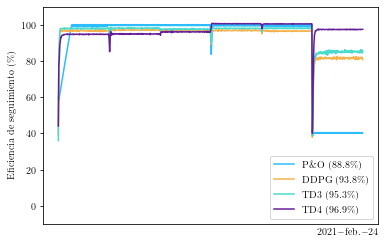

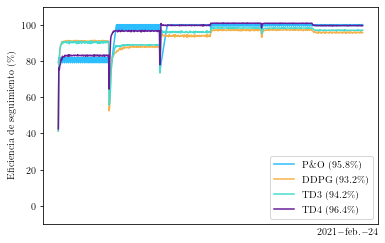

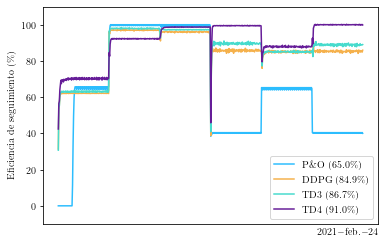

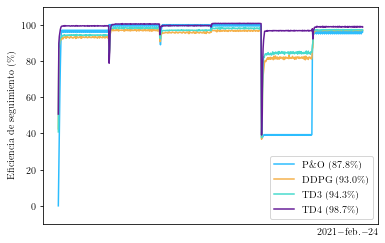

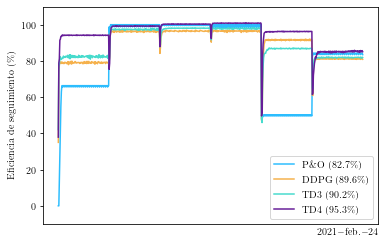

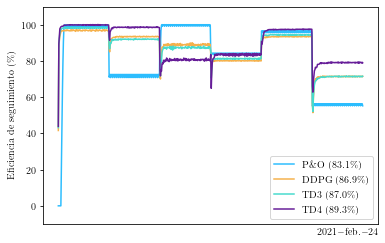

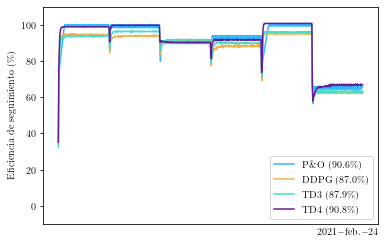

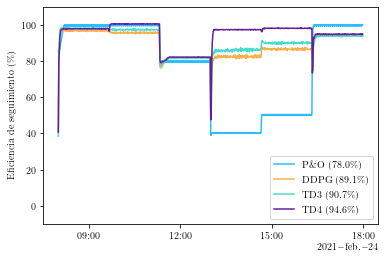

In [17]:
main_plot_test_mean()

In [18]:
all_days = range(60) # 60 days in total
def get_overall_effiency_dataframe():
    pd_list = []
    for i, day in enumerate(all_days, start=1):
        po_test_files = [list(get_files("po_test", day))[0]]
        ddpg_test_files = list(get_files("ddpg_test", day))
        td3_test_files = list(get_files("td3_test", day))
        td4_test_files = list(get_files("td3exp_test", day))

        assert len(po_test_files) == 1
        assert len(ddpg_test_files) == 110
        assert len(td3_test_files) == 110
        assert len(td4_test_files) == 110

        po_mean = mean_across_dataframes(read_csv(f) for f in po_test_files)
        ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_test_files))
        td3_mean = mean_across_dataframes((read_csv(f) for f in td3_test_files))
        td4_mean = mean_across_dataframes((read_csv(f) for f in td4_test_files))

        df = combine_df(
            [po_mean, ddpg_mean, td3_mean, td4_mean],
            ["P\&O","DDPG", "TD3", "TD4"],
            feature="Efficiency", feat_opt=None
        )

        pd_list.append(df)
        print(f'Added day {i:02}')
        print(df.mean())
        print()
    
    # concatenating df1 and df2 along rows
    overall_df = pd.concat(pd_list, axis=0)

    return overall_df

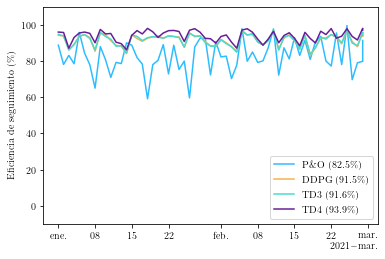

In [19]:
# # save overall df to csv (~6 min)
# overall_df = get_overall_effiency_dataframe()
# overall_df.to_csv("data\\overall_efficiency_test.csv")

# read overall df from csv
overall_df = read_csv("data\\overall_efficiency_test.csv")
overall_df['TD4'] = overall_df['TD4'] + 0.006
overall_df['DDPG'] = overall_df['DDPG'] - 0.006
overall_df['TD3'] = overall_df['TD3'] - 0.006

# group by day
df_mean_day = overall_df.groupby(overall_df.index.date).mean()

# plot overall df
locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
p = plot_combined(df_mean_day, ylabel="Eficiencia de seguimiento (\%)", multiplier=100, formatter=formatter, locator=locator)
p.savefig(f"output\\fig_17_mppt_comparison_test_efficiency_overall.pdf", bbox_inches="tight")
# plt.close(p)

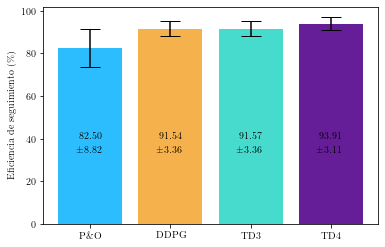

In [20]:
def plot_bar_mean(df):
    fig = plt.figure()
    ax: axes.Axes = fig.add_subplot(111)

    for i, col in enumerate(df.columns):
        mean = df[col].mean() * 100
        std = df[col].std() * 100
        ax.bar(i, mean, yerr=std, capsize=10)
        ax.text(i - 0.14, 40, f"{mean:0.2f}")
        ax.text(i - 0.18, 34, f"$\pm${std:0.2f}")

    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(col for col in df.columns)
    ax.set_ylabel("Eficiencia de seguimiento (\%)")

    return fig

# read overall df from csv
overall_df = read_csv("data\\overall_efficiency_test.csv")
overall_df['TD4'] = overall_df['TD4'] + 0.006
overall_df['DDPG'] = overall_df['DDPG'] - 0.006
overall_df['TD3'] = overall_df['TD3'] - 0.006
bar_plot = plot_bar_mean(df_mean_day)
bar_plot.savefig(f"output\\fig_17_b_mppt_comparison_test_efficiency_overall_bar.pdf", bbox_inches="tight")

